In [1]:
import os
import logging
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from paper.utils import setup_logging

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH,
    BUILD_DIR
)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

logger = logging.getLogger(__name__)

os.makedirs(BUILD_DIR, exist_ok=True)
setup_logging(dir=BUILD_DIR, fname="PCA")


2024-10-28 10:16:19,333 - paper.utils.utils - INFO - Logging to /home/andres/repos/rat-mapping-paper/reports/J_RCML_000/PCA.log


In [2]:
raw = np.load("/home/andres/data/hbmep-processed/rat/J_RCML_000/mat.npy")
keep_response = [0, 1, 3, 4, 5, 6,]
target_response = 0
raw = raw[..., keep_response]

config = Config(toml_path=TOML_PATH)
config.BUILD_DIR = BUILD_DIR
config.RESPONSE = [config.RESPONSE[target_response]]
model = NonHierarchicalBayesianModel(config=config)

model.mep_response = np.array(model.mep_data['mep_response'])[keep_response].tolist()
model.mep_window = model.mep_data['mep_window']
model.mep_size_window = model.mep_data['mep_size_window']

df = pd.read_csv(DATA_PATH)


2024-10-28 10:16:21,241 - hbmep.model.baseline - INFO - Initialized non_hierarchical_bayesian_model


In [6]:
subset = [('amap01', '-C5M')]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
curr_df = df[ind].reset_index(drop=True).copy()
curr_mat = raw[ind, ...]

destination_path = os.path.join(model.build_dir, "subset.pdf")
model.plot(df=curr_df, mep_matrix=curr_mat, destination_path=destination_path)


2024-10-28 10:17:00,180 - hbmep.plotter.core - INFO - Rendering dataset ...
2024-10-28 10:17:00,376 - hbmep.plotter.core - INFO - Saved to /home/andres/repos/rat-mapping-paper/reports/J_RCML_000/subset.pdf
2024-10-28 10:17:00,377 - hbmep.utils.utils - INFO - func:plot took: 0.20 sec


In [24]:
curr_mat = raw[ind, ...]

In [26]:
curr_mat.shape

(51, 428, 6)

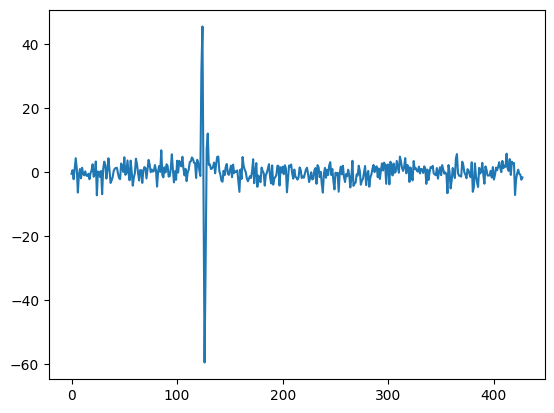

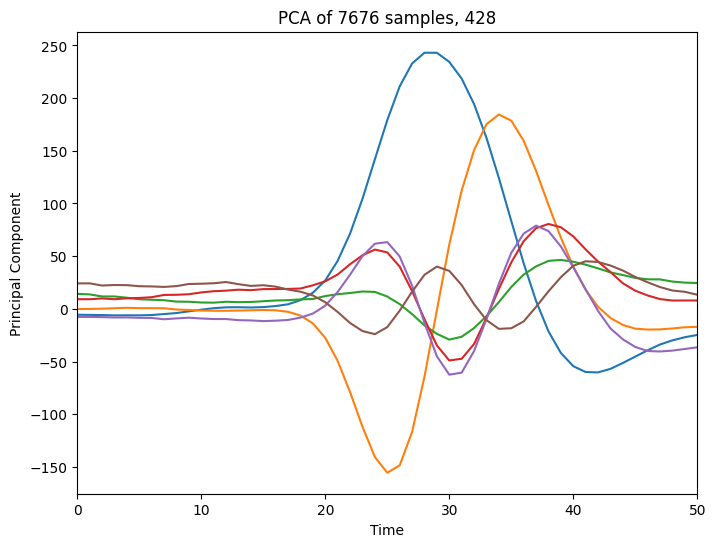

In [14]:
raw_one = raw[..., :,0]
raw_one = raw_one.transpose()

raw_one = raw_one[150:,:]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(raw_one)
pca = PCA(n_components=6)  # You can choose a different number of components
principal_components = pca.fit_transform(data_scaled)


plt.figure(figsize=(8, 6))
for i in range(0, 6):
    plt.plot(np.arange(0, 278), principal_components[:, i])
    plt.title('PCA of 7676 samples, 428')
    plt.xlabel('Time')
    plt.ylabel('Principal Component')
    
plt.xlim(0, 50)
plt.show()

In [15]:
rsquare_arr = []

for i2 in range(len(data_scaled[0,:])):
    for i in range(0, 6):
        rsquare = stats.linregress(principal_components[:, i], data_scaled[:, i2]).rvalue**2
        rsquare_arr.append(rsquare)
        
rsquare_arr = np.array(rsquare_arr)
rsquare_arr = rsquare_arr.reshape(len(data_scaled[0,:]), 6)
rsquare_arr.shape


(7676, 6)

In [6]:
c5L = df[(df['compound_position'] == '-C5L')&(df['participant'] == 'amap01')].index
c5M = df[(df['compound_position'] == '-C5M')&(df['participant'] == 'amap01')].index

AttributeError: 'Axes' object has no attribute 'add_subplot'

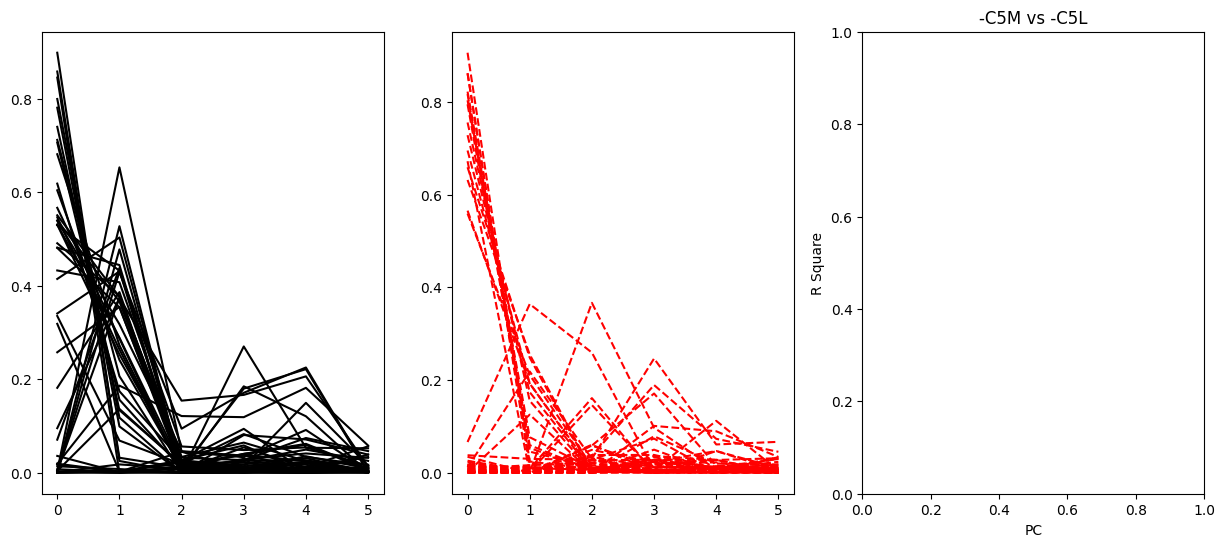

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for i in c5L:
    ax[0].plot(rsquare_arr[i], color = 'black')
    plt.title('-C5L')
    plt.xlabel('PC')
    plt.ylabel('R Square')
for i in c5M:
    ax[1].plot(rsquare_arr[i], linestyle='dashed', color = 'red')
    plt.title('-C5M vs -C5L')
    plt.xlabel('PC')
    plt.ylabel('R Square')
    
inner_ax = ax[0].add_subplot(2, 1, 1)

for i in range(0, 6):
    ax[2].plot(np.arange(0, 278), principal_components[:, i])
    ax[2].set_xlim(0, 50)


In [8]:
PCs_T = principal_components.T

(6, 278)

In [9]:
projection = np.dot(PCs_T, raw_one)

In [75]:
normalized_projection = projection / np.sum(projection, axis=0)


In [110]:
(projection/np.sum(projection, axis=0))[:,7]

array([ 3.80409425, -1.48038938, -1.23383672,  3.09268657, -0.96330439,
       -2.21925035])

In [111]:
projection[:,7]

array([ 2435.31441157,  -947.71931134,  -789.88062205,  1979.8836958 ,
        -616.69057196, -1420.72514321])

In [77]:
target_positions = df.compound_position.unique()

In [99]:
normalized_projection[:,7]

array([ 3.80409425, -1.48038938, -1.23383672,  3.09268657, -0.96330439,
       -2.21925035])

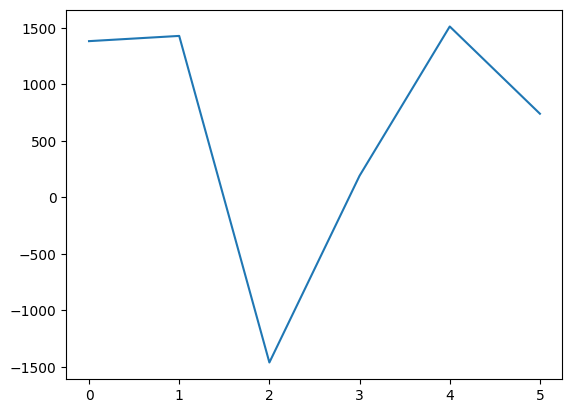

In [115]:
plt.plot(projection[:,10])

In [56]:
plt.figure(figsize=(8, 6))
for i in range(0, 6):
    plt.plot(projection[i])
    plt.title('Idk')
    plt.xlabel('PC')
    plt.ylabel('Contribution')
    
plt.xlim(0, 50)
plt.show()

NameError: name 'projection' is not defined

<Figure size 800x600 with 0 Axes>

# Plot

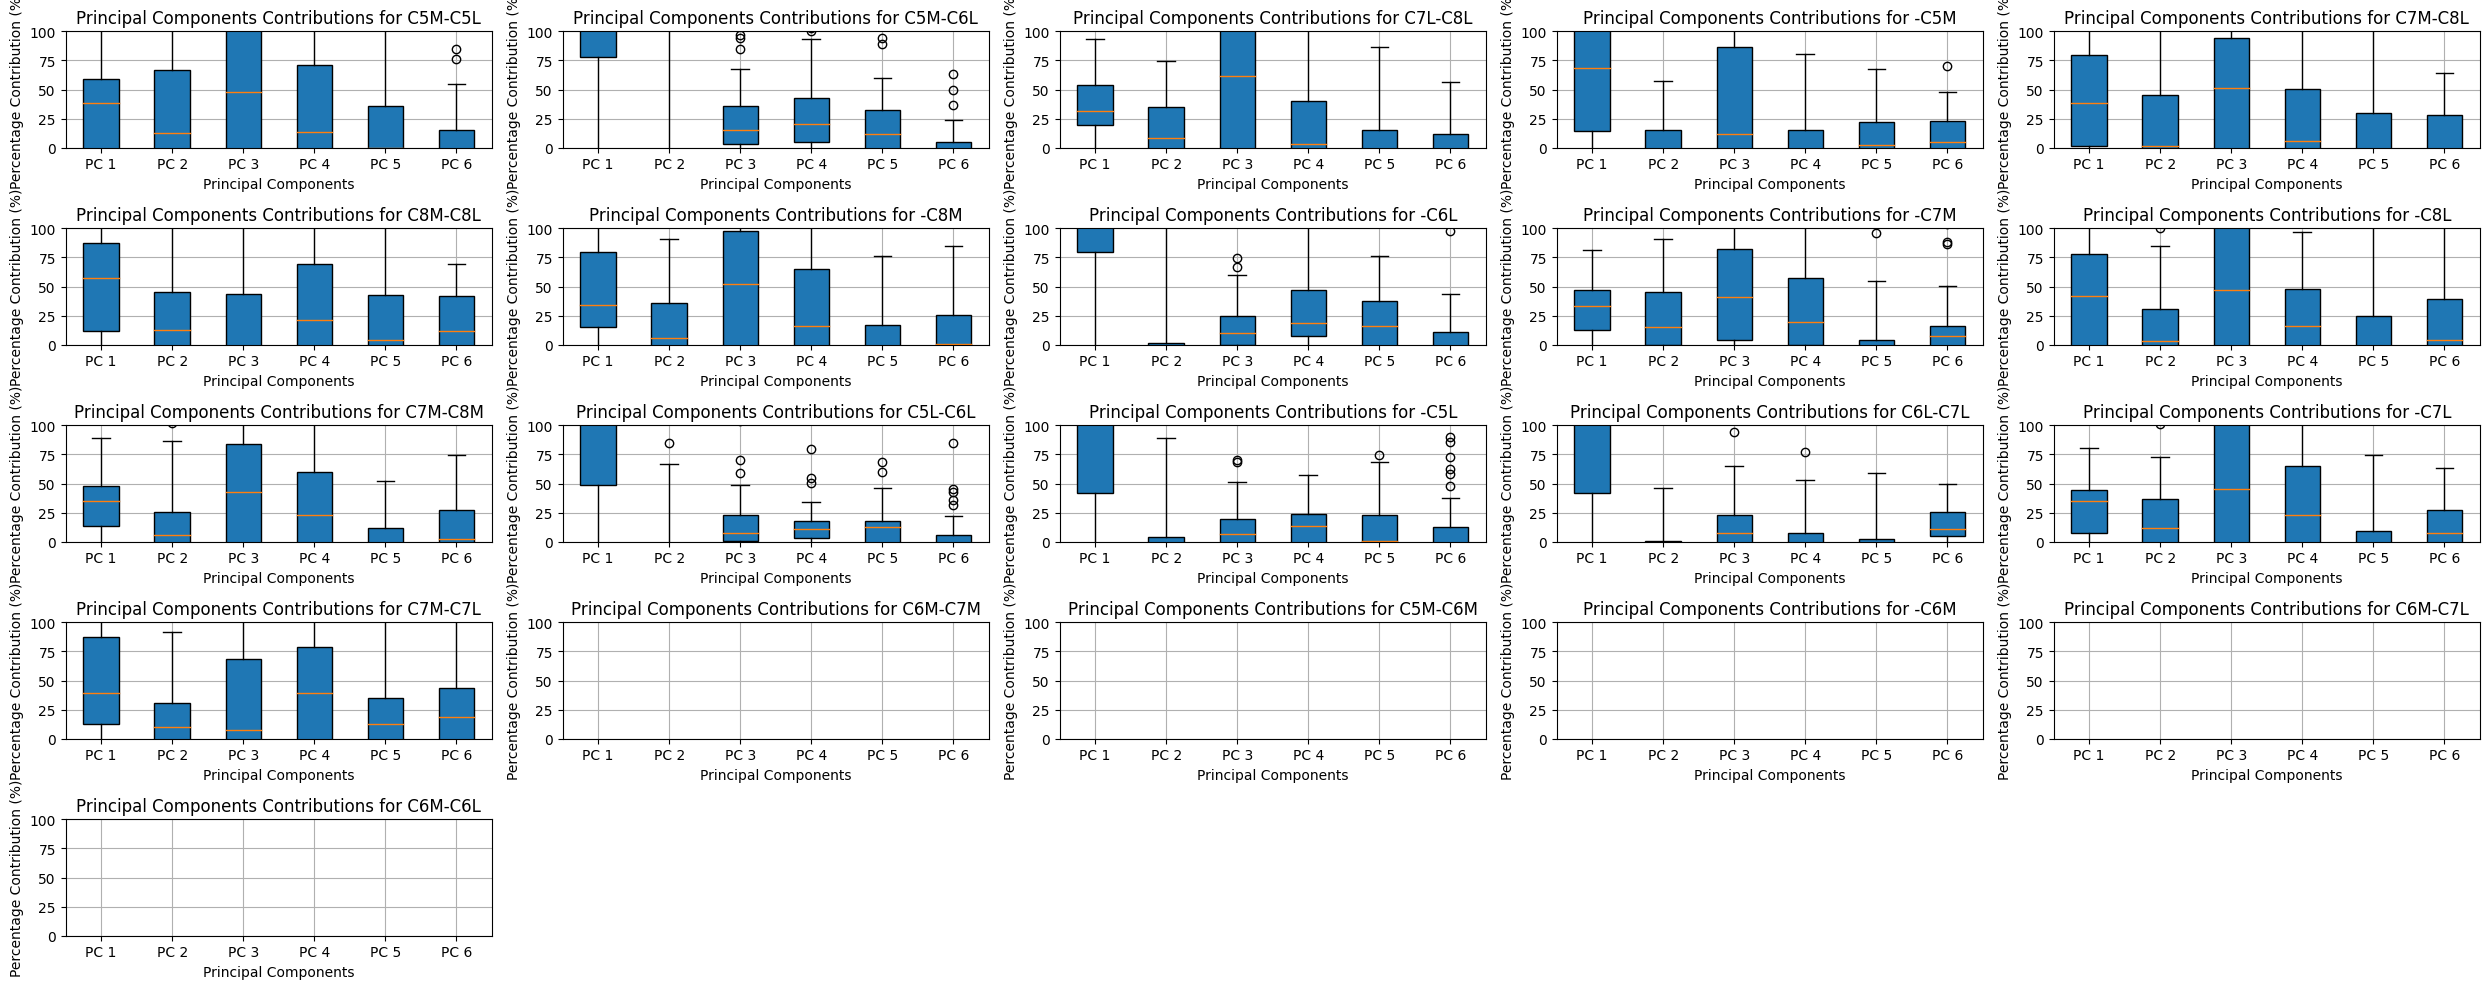

In [71]:
num_rows = 5  
num_cols = 5  
total_plots = num_rows * num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 10))  
axs = axs.flatten()

for idx, t in enumerate(target_positions):
    ind_temp = df.index[(df['compound_position'] == t) & (df['participant'] == "amap01")].tolist()
    pc_subset_df = pc_df[ind_temp]

    axs[idx].boxplot([pc_subset_df.iloc[i] for i in range(6)],
                     labels=[f'PC {i+1}' for i in range(6)],
                     patch_artist=True)

    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    for patch, color in zip(axs[idx].artists, colors):
        patch.set_facecolor(color)

    axs[idx].set_title(f'Principal Components Contributions for {t}')
    axs[idx].set_xlabel('Principal Components')
    axs[idx].set_ylabel('Percentage Contribution (%)')
    axs[idx].set_ylim(0, 100)
    axs[idx].grid()

for j in range(len(target_positions), total_plots):
    axs[j].axis('off')  # Hide the unused subplots

plt.tight_layout() 
plt.show()  # Display the plots

In [72]:
pc_df

,0,1,2,3,4,5,6,7,8,9,...,7666,7667,7668,7669,7670,7671,7672,7673,7674,7675
0,55.978681,-65.380027,22.214841,53.604644,-152.421774,43.515148,-121.671546,380.409425,-118.303130,40.006375,...,90.961251,243.619155,254.038060,390.873863,165.204282,465.086825,502.407633,25.641661,-814.892894,1128.372154
1,24.490415,-36.024088,56.830623,-22.187214,-3.511776,27.694928,90.760111,-148.038938,94.893675,-4.963247,...,38.799206,-150.093089,-138.571976,-378.940046,-89.864991,-468.746596,-496.638175,3.319491,1271.667635,-1313.854183
2,13.951929,57.962475,-20.457421,75.884889,116.313116,18.688515,-173.746776,-123.383672,124.079172,79.577681,...,-8.775871,-7.508399,-13.827887,9.716687,-5.603257,8.592555,-0.932446,68.131303,-83.227852,27.132693
3,-19.413029,50.258221,133.060105,39.517912,-18.418800,9.469034,520.794067,309.268657,28.354084,27.165611,...,-10.328481,6.892642,1.506752,47.205443,16.428053,60.728832,58.096989,-45.871403,-217.321863,191.731285
4,12.120865,207.688107,-63.630061,-41.134674,149.613067,5.953672,60.735467,-96.330439,-2.751588,-53.929082,...,-7.768045,18.104905,2.387059,70.401461,24.027039,85.667121,79.921462,29.540119,-202.710093,215.942217
5,12.871139,-114.504687,-28.018088,-5.685557,8.426166,-5.321297,-276.871323,-221.925035,-26.272212,12.142662,...,-2.888060,-11.015214,-5.532008,-39.257410,-10.191127,-51.328736,-42.855463,19.238829,146.485067,-149.324167


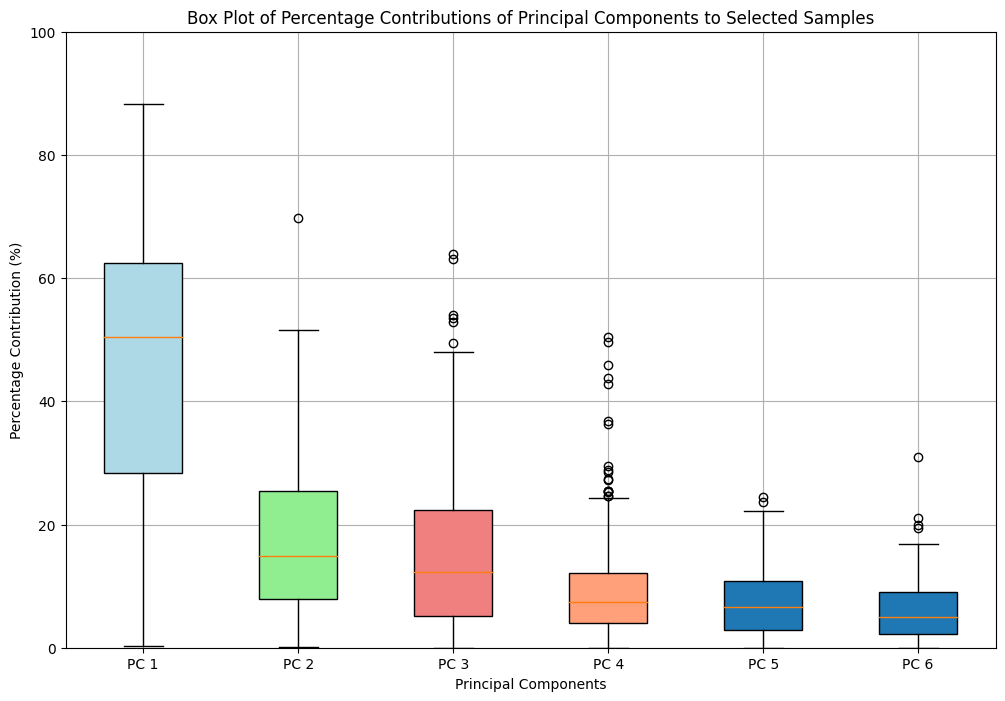

In [7]:


# Select a subset of samples to visualize (for example, samples 0 to 99)
subset_indices = c6L  # Adjust as needed for different subsets



In [58]:
principal_components[3]

array([-2.21558558,  0.44066843, -0.1923451 , -0.2517875 , -0.40114799,
       -0.00614132])

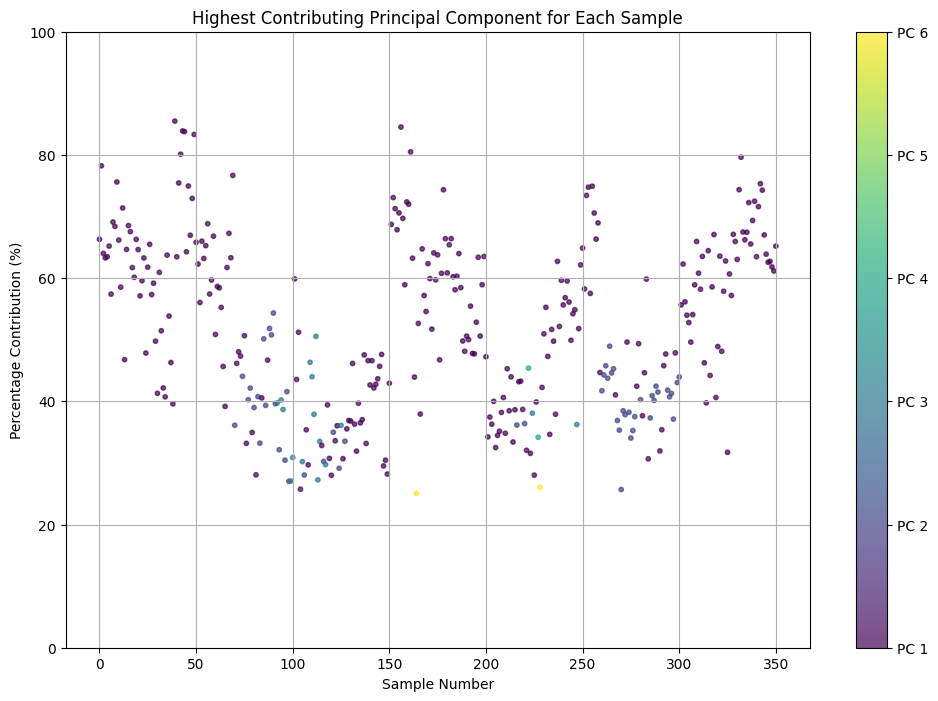

In [16]:
plt.figure(figsize=(12, 8))  # Adjust as needed for different subsets

sample_contributions = np.abs(principal_components)
total_contribution = np.sum(sample_contributions, axis=1, keepdims=True)
pc_percentage_contributions_per_sample = (sample_contributions / total_contribution) * 100

pc_percentage_contributions_per_sample_subset = pc_percentage_contributions_per_sample[c5M]

# Determine the highest contributing PC for each sample
highest_pc_indices = np.argmax(pc_percentage_contributions_per_sample_subset, axis=1)
highest_pc_values = np.max(pc_percentage_contributions_per_sample_subset, axis=1)

scatter = plt.scatter(np.arange(0, len(pc_percentage_contributions_per_sample_subset)), highest_pc_values, c=highest_pc_indices, cmap='viridis', alpha=0.7, s=10)
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, n_components))
cbar.set_ticklabels([f'PC {i+1}' for i in range(n_components)])

plt.title('Highest Contributing Principal Component for Each Sample')
plt.xlabel('Sample Number')
plt.ylabel('Percentage Contribution (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()

In [98]:
n_components

6

In [ ]:
raw_one = raw[..., :, 0]  # Analyze the first muscle or signal

# Standardize the data across time points
scaler = StandardScaler()
data_scaled = scaler.fit_transform(raw_one.reshape(-1, raw_one.shape[-1]))  # Reshape for scaling

# Apply PCA
n_components = 4  # Using 4 principal components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(data_scaled)

# Calculate contributions of each sample to the principal components
sample_contributions = np.abs(principal_components)

# Calculate total contributions and percentage contributions
total_contribution = np.sum(sample_contributions, axis=1, keepdims=True)
pc_percentage_contributions_per_sample = (sample_contributions / total_contribution) * 100

# Create a DataFrame for easier plotting
pc_df = pd.DataFrame(pc_percentage_contributions_per_sample, columns=[f'PC{i+1}' for i in range(n_components)])

# Create a box plot for the contributions of each PC
plt.figure(figsize=(12, 8))
plt.boxplot([pc_df[f'PC{i+1}'] for i in range(n_components)], labels=[f'PC {i+1}' for i in range(n_components)], patch_artist=True)

# Customize box colors
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
for patch, color in zip(plt.gca().patches, colors):
    patch.set_facecolor(color)

plt.title('Box Plot of Percentage Contributions of Principal Components to Samples')
plt.xlabel('Principal Components')
plt.ylabel('Percentage Contribution (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()